# Sentiment Analysis

In [1]:
# Required modules

import re
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
# Loading the data

data = pd.read_csv('./data/tweets.zip', compression='zip')
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1262787913311387649,1262787913311387649,1589907074000,2020-05-19,16:51:14,UTC,1250079805980045318,dramaflick,The Drama Flick,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1250079805980045318', 'username'...",NaN,NaN,NaN,NaN
1,1262787786152620040,1262787786152620040,1589907044000,2020-05-19,16:50:44,UTC,807843238648299520,knowpuneet,TravelTrainee,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '807843238648299520', 'username':...",NaN,NaN,NaN,NaN
2,1262787219498000384,1262787219498000384,1589906909000,2020-05-19,16:48:29,UTC,1085426639570235392,narasinhpurohit,Narasinh Purohit,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1085426639570235392', 'username'...",NaN,NaN,NaN,NaN
3,1262786998592434176,1262786998592434176,1589906856000,2020-05-19,16:47:36,UTC,1104213868467806208,ka_trolls,Humans Of Hindutva,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1104213868467806208', 'username'...",NaN,NaN,NaN,NaN
4,1262786970163441669,1262786970163441669,1589906849000,2020-05-19,16:47:29,UTC,392180204,rajendrabohora,rajendrabohora,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '392180204', 'username': 'rajendr...",NaN,NaN,NaN,NaN


In [3]:
# Inspecting the data

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124384 entries, 0 to 124383
Data columns (total 34 columns):
id                 124384 non-null int64
conversation_id    124384 non-null int64
created_at         124384 non-null int64
date               124384 non-null object
time               124384 non-null object
timezone           124384 non-null object
user_id            124384 non-null int64
username           124384 non-null object
name               124384 non-null object
place              9143 non-null object
tweet              124384 non-null object
mentions           124384 non-null object
urls               124384 non-null object
photos             124384 non-null object
replies_count      124384 non-null int64
retweets_count     124384 non-null int64
likes_count        124384 non-null int64
hashtags           124384 non-null object
cashtags           124384 non-null object
link               124384 non-null object
retweet            124384 non-null bool
quote_url         

,id,conversation_id,created_at,user_id,replies_count,retweets_count,likes_count,video,near,geo,source,user_rt_id,user_rt,retweet_id,retweet_date,translate,trans_src,trans_dest
count,1.243840e+05,1.243840e+05,1.243840e+05,1.243840e+05,124384.000000,124384.000000,124384.000000,124384.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.248684e+18,1.248494e+18,1.586544e+12,4.351165e+17,0.667626,2.077044,7.881858,0.061953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.229079e+16,2.304835e+16,5.369331e+09,5.240636e+17,11.845734,28.424693,121.299772,0.241072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8.660923e+08,8.660923e+08,1.216819e+12,3.160000e+03,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.243007e+18,1.242870e+18,1.585191e+12,2.617597e+08,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.247014e+18,1.246851e+18,1.586146e+12,2.940158e+09,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.256459e+18,1.256427e+18,1.588398e+12,9.912536e+17,0.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.263035e+18,1.263035e+18,1.589966e+12,1.262808e+18,2044.000000,3710.000000,19929.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dealing with Missing values

In [4]:
nan_cols = data.columns[data.isna().any()]
print("Columns which contains missing values: ")
nan_cols

Columns which contains missing values: 


Index(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

In [5]:
print("Percentage of Missing values in the columns: ")
(data[nan_cols].isna().sum()) / len(data)

Percentage of Missing values in the columns: 


place           0.926494
quote_url       0.895220
near            1.000000
geo             1.000000
source          1.000000
user_rt_id      1.000000
user_rt         1.000000
retweet_id      1.000000
retweet_date    1.000000
translate       1.000000
trans_src       1.000000
trans_dest      1.000000
dtype: float64

In [6]:
# Dropping all the columns which consists of missing values
data.drop(nan_cols, axis=1, inplace=True)

In [7]:
print(data.columns)

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'video', 'reply_to'],
      dtype='object')


By careful inspection, we can observe that all the columns except 'tweet' and 'hashtags' are redundant and can be dropped.

In [8]:
actual_data = data[['tweet', 'hashtags']][:2000]
actual_data

,tweet,hashtags
0,https://www.youtube.com/watch?v=-CRbO7ExO1k …...,"['#lockdownindia', '#lockdown', '#indiafightsc..."
1,Lockdown 4.0 ka.naam hi lockdown hai\nHai sab ...,"['#lockdownindia', '#locldown4']"
2,CORONA VIRUS THREAT-\nHOW TO OVERCOME STRESS A...,"['#covid_19', '#covid_19sa', '#covid_19india',..."
3,Could you please\n\n#lockdownindia\n@Bhuvan_Ba...,"['#lockdownindia', '#roastchallenge', '#journa..."
4,"In fight with #COVID19, You are the best Docto...","['#covid19', '#coronavirus', '#patiencechallen..."
...,...,...
1995,Dukh me google maps uninstall kar diya maine ☹...,"['#lockdown4', '#lockdownindia', '#covid__19',..."
1996,What did we achieve by #lockdownindia \n\nA ne...,['#lockdownindia']
1997,Finally...\nYesterday night I reached home fro...,['#lockdownindia']
1998,#MigrantWorkers FM @nsitharaman Just think ove...,"['#migrantworkers', '#lockdownindia']"


## Preprocessing data

In [9]:
# Removing all the unwanted information from of data

actual_data['tweet'] = actual_data['tweet'].apply(lambda x: re.sub(r'#\w+', ' ', x))                                                                
actual_data['tweet'] = actual_data['tweet'].apply(lambda x: re.sub(r'\n', ' ', x))                                                                  
actual_data['tweet'] = actual_data['tweet'].apply(lambda x: re.sub(r'pic.twitter.com/\w+', ' ', x))                                                            
actual_data['tweet'] = actual_data['tweet'].apply(lambda x: re.sub(r'@\w+', ' ', x))
actual_data['tweet'] = actual_data['tweet'].apply(lambda x: re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\.\?\-\=/]+\xa0', ' ', x))

In [10]:
# Making a copy of original dataset to be used for different strategy

data1 = actual_data.copy()
data2 = actual_data.copy()
data3 = actual_data.copy()

## Lexicon based sentiment analysis

### TextBlob
This sentiment analysis is done using TextBlob function of the module textblob.

In [11]:
data1['sentiment'] = data1['tweet'].apply(lambda x: TextBlob(x).sentiment)

In [12]:
data1['polarity_value'] = data1['sentiment'].apply(lambda x: x[0])
data1['subjectivity'] = data1['sentiment'].apply(lambda x: x[1])

In [13]:
data1['polarity_type'] = np.where(data1['polarity_value'].values > 0, 'Positive', np.where(data1['polarity_value'].values < 0, 'Negative', 'Neutral'))

In [14]:
# Count of each type of tweets

data1['polarity_type'].value_counts()

Positive    873
Neutral     789
Negative    338
Name: polarity_type, dtype: int64

#### Visualization of data

<BarContainer object of 3 artists>

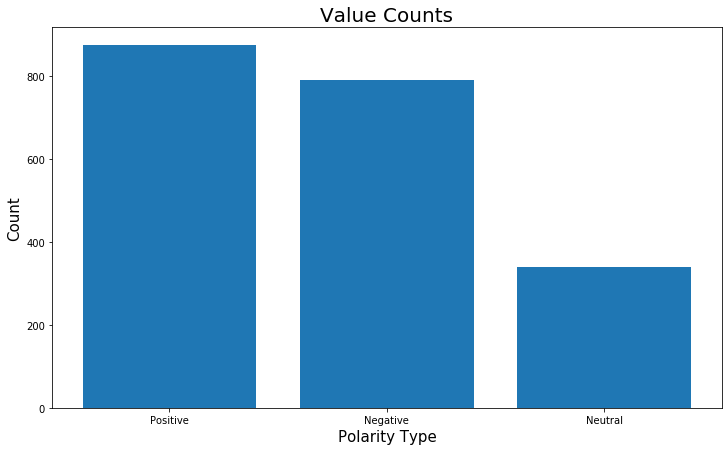

In [15]:
# Polarity count

_, ax = plt.subplots()
ax.set_title("Value Counts", fontsize=20)
ax.set_xlabel("Polarity Type", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.bar(data1['polarity_type'].unique(), height=data1['polarity_type'].value_counts())

(array([  9.,   0.,   2.,   5.,   3.,  33.,  31.,  51.,  90., 114., 969.,
        232., 111., 126.,  22., 124.,  32.,   5.,  18.,  23.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 20 Patch objects>)

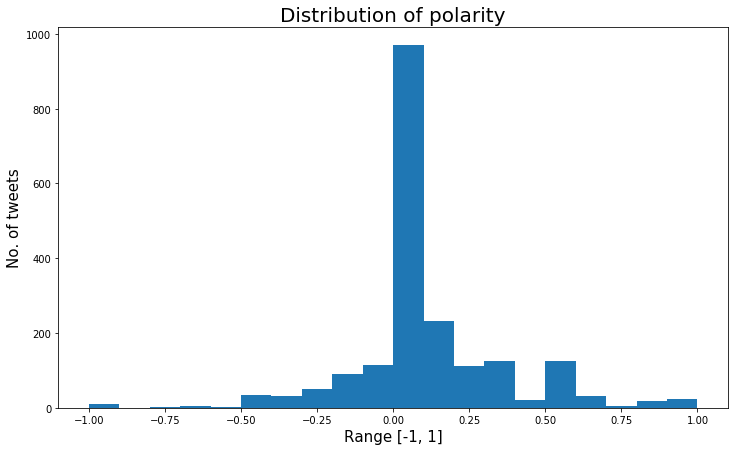

In [16]:
# Distribution of the polarity value

_, ax = plt.subplots()
ax.set_title("Distribution of polarity", fontsize=20)
ax.set_xlabel("Range [-1, 1]", fontsize=15)
ax.set_ylabel("No. of tweets", fontsize=15)

ax.hist(data1['polarity_value'], bins=20)

### VaderSentiment
This sentiment analysis is done using VaderSentiment module

In [17]:
analyzer = SentimentIntensityAnalyzer()

data2['sentiment'] = data2['tweet'].apply(lambda x: analyzer.polarity_scores(x))

In [18]:
data2['positive'] = data2['sentiment'].apply(lambda x: x['pos'])
data2['negative'] = data2['sentiment'].apply(lambda x: x['neg'])
data2['neutral'] = data2['sentiment'].apply(lambda x: x['neu'])

data2['polarity_value'] = data2['sentiment'].apply(lambda x: x['compound'])

In [19]:
data2['polarity_type'] = np.where(data2['polarity_value'].values > 0.05, 'Positive', np.where(data2['polarity_value'].values < -0.05, 'Negative', 'Neutral'))

In [20]:
# Count of each type of tweets

data2['polarity_type'].value_counts()

Positive    850
Neutral     655
Negative    495
Name: polarity_type, dtype: int64

#### Visulization of data

<BarContainer object of 3 artists>

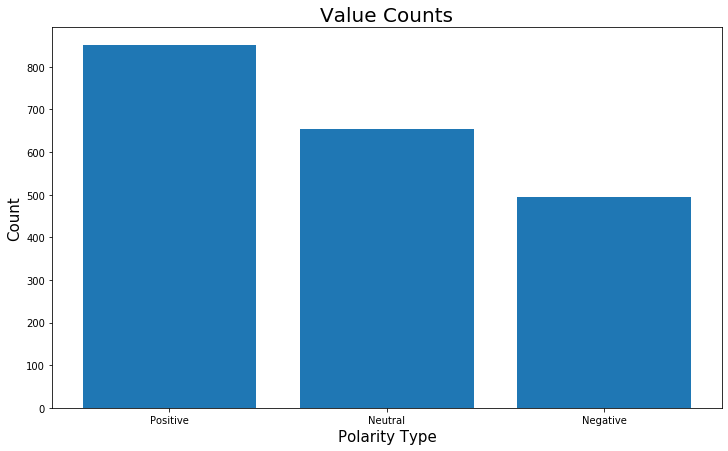

In [21]:
# Polarity count

_, ax = plt.subplots()
ax.set_title("Value Counts", fontsize=20)
ax.set_xlabel("Polarity Type", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.bar(data2['polarity_type'].unique(), height=data2['polarity_type'].value_counts())

(array([  6.,   2.,  16.,  16.,  63., 119., 221., 346., 420., 791.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

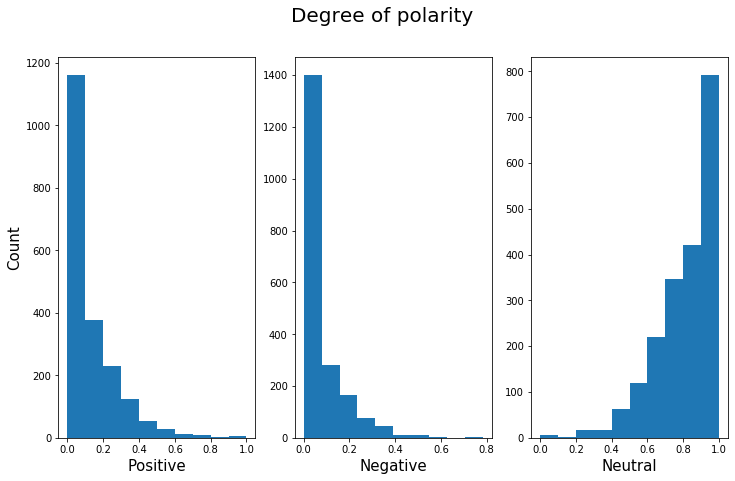

In [22]:
# Degree of polarity

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.suptitle("Degree of polarity", fontsize=20)
ax[0].set_xlabel("Positive", fontsize=15)
ax[1].set_xlabel("Negative", fontsize=15)
ax[2].set_xlabel("Neutral", fontsize=15)
ax[0].set_ylabel("Count", fontsize=15)

ax[0].hist(data2['positive'])
ax[1].hist(data2['negative'])
ax[2].hist(data2['neutral'])

## Machine Learning based Sentiment Analysis

In [23]:
# Loading the data

imdb_data = pd.read_csv('./data/imdb_data.zip', compression='zip')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [24]:
# Inspecting data

imdb_data.info()
imdb_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Preprocessing

In [25]:
# Some preprocssing
# There are some html break tags(replacing them with ' ')

imdb_data['review'] = [re.sub(r'<.*?>', ' ', review) for review in imdb_data['review']]

In [26]:
# Adding few columns

imdb_data['review_len'] = imdb_data['review'].apply(lambda x: len(x.split()))

In [27]:
# Converting 'sentiment' into numerical value

imdb_data['sentiment_numerical'] = np.where(imdb_data['sentiment'] == 'positive', 1, 0)

In [28]:
# Separating out features and labels

X = imdb_data['review']
y = imdb_data['sentiment_numerical']

In [29]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [ ]:
max_words = 10000
oov_token = '<OOV>'

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)

In [ ]:
tokenizer.fit_on_texts(X)
tokenizer.word_index

In [ ]:
# Converting tokens into Sequences

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_train_word = int(np.mean(imdb_data['review_len']) + 2 * np.std(imdb_data['review_len']))

In [ ]:
pad_type = 'pre'

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokens, maxlen=max_train_word, padding=pad_type, truncating=pad_type)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokens, maxlen=max_train_word, padding=pad_type, truncating=pad_type)

In [ ]:
# Defining the model

embedding_dim = 8

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words,
                             output_dim=embedding_dim,
                             input_length=max_train_word,
                             name='embedding_layer'),
    tf.keras.layers.LSTM(units=16, return_sequences=True),
    tf.keras.layers.LSTM(units=8, return_sequences=True),
    tf.keras.layers.LSTM(units=4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Defining the optimizer

optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [ ]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
# Model fitting on the training data

epochs=1
batch_size = 64

history = model.fit(X_train_padded, y_train, validation_split=0.05, epochs=epochs, batch_size=batch_size)

In [ ]:
train_loss = model.evaluate(X_train_padded, y_train)
print("Training accuracy: {:6f}".format(train_loss[1]))

In [ ]:
test_loss = model.evaluate(X_test_padded, y_test)
print("Testing accuracy: {:6f}".format(test_loss[1]))

# Now introducing the original data

In [ ]:
data3